In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from IPython.display import HTML, display
import numpy as np
import dataframe_image as dfi

from utils.diagnostics import compute_summary_statistics
from utils.dataset_utils import aggregate_results

plt.style.use('bmh')
plt.rcParams['lines.linewidth'] = 1

In [2]:
results_path = os.path.join(os.getcwd(), "results")
data_path = os.path.join(os.getcwd(), "data", "inputs")

group_names = ["mvo", "rpo", "rbmvo", "rbmvog"]
model_names = [

    "ew_lo", "mvo_lo_mle_mle"

]
stats_order = ["E[R]", "Std(R)", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]

vol_target = 0.2

## 0) Dataset description

In [3]:
data = pd.read_csv(os.path.join(data_path, "etfs.csv"))
data.loc[:, "date"] = pd.to_datetime(data["date"])
data.set_index("date", inplace=True)

In [4]:
data.shape

(3842, 21)

In [5]:
data.isnull().any()

SPY    False
IWM    False
EEM    False
TLT    False
USO    False
GLD    False
XLF    False
XLB    False
XLK    False
XLV    False
XLI    False
XLU    False
XLY    False
XLP    False
XLE    False
VIX    False
AGG    False
DBC    False
HYG    False
LQD    False
UUP    False
dtype: bool

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
SPY,3842.0,0.000467,0.012573,-0.109424,-0.003673,0.000504,0.005671,0.145198
IWM,3842.0,0.000441,0.015691,-0.132669,-0.006389,0.000607,0.007834,0.091491
EEM,3842.0,0.000304,0.018590,-0.161662,-0.007740,0.000405,0.008462,0.227699
TLT,3842.0,0.000291,0.009218,-0.066683,-0.004948,0.000202,0.005516,0.075196
USO,3842.0,-0.000240,0.023320,-0.253150,-0.010983,0.000000,0.011466,0.166667
GLD,3842.0,0.000303,0.011048,-0.087808,-0.004883,0.000174,0.005643,0.112905
XLF,3842.0,0.000368,0.020462,-0.166667,-0.006574,0.000000,0.007879,0.164005
XLB,3842.0,0.000433,0.015500,-0.124121,-0.006118,0.000515,0.008042,0.140576
XLK,3842.0,0.000674,0.013925,-0.138140,-0.004694,0.000780,0.006882,0.138983
XLV,3842.0,0.000498,0.011033,-0.098610,-0.004085,0.000509,0.005940,0.120547


## 1) Summary Statistics of the Portfolios

In [7]:
all_summary = []

for model in model_names:

        output_path = os.path.join(os.getcwd(),
                                   "data",
                                   "outputs",
                                   model)
    
        summary = aggregate_results(path=output_path)

        # compute pnl
        summary["pnl"] = summary["returns"] * summary["weights"]

        # add model name
        summary["model"] = model

        # save summary
        all_summary.append(summary)
all_summary_df = pd.concat(all_summary, axis=0)

In [8]:

all_stats = {}
for model in model_names:

    portfolio_returns = all_summary_df.loc[all_summary_df["model"] == model].groupby("date").sum()[["pnl"]]
    portfolio_vol = (portfolio_returns.rolling(window=252).std() * np.sqrt(252)).shift(1)
    portfolio_returns_target =  torch.tensor((portfolio_returns * (vol_target / portfolio_vol)).dropna().to_numpy())
    stats = compute_summary_statistics(portfolio_returns=portfolio_returns_target)

    all_stats[model] = stats
all_stats_df = pd.DataFrame(all_stats).T[stats_order]

dfi.export(all_stats_df, os.path.join(results_path, "all_stats_lo_df.png"))
display(HTML(all_stats_df.to_html()))

,E[R],Std(R),Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
ew_lo,15.573063,22.084686,0.705152,0.840603,-12.007568,-47.730486,0.523120
mvo_lo_mle_mle,-5.483590,20.924107,-0.262070,-0.319340,-44.522564,-75.555698,0.503147


In [9]:
print(all_stats_df.reset_index().to_latex(index=False))

\begin{tabular}{lrrrrrrr}
\toprule
         index &      E[R] &    Std(R) &    Sharpe &   Sortino &      AvgDD &      MaxDD &  \% Positive Ret. \\
\midrule
         ew\_lo & 15.573063 & 22.084686 &  0.705152 &  0.840603 & -12.007568 & -47.730486 &         0.523120 \\
mvo\_lo\_mle\_mle & -5.483590 & 20.924107 & -0.262070 & -0.319340 & -44.522564 & -75.555698 &         0.503147 \\
\bottomrule
\end{tabular}



## 2) Cummulative Returns of the Portfolios

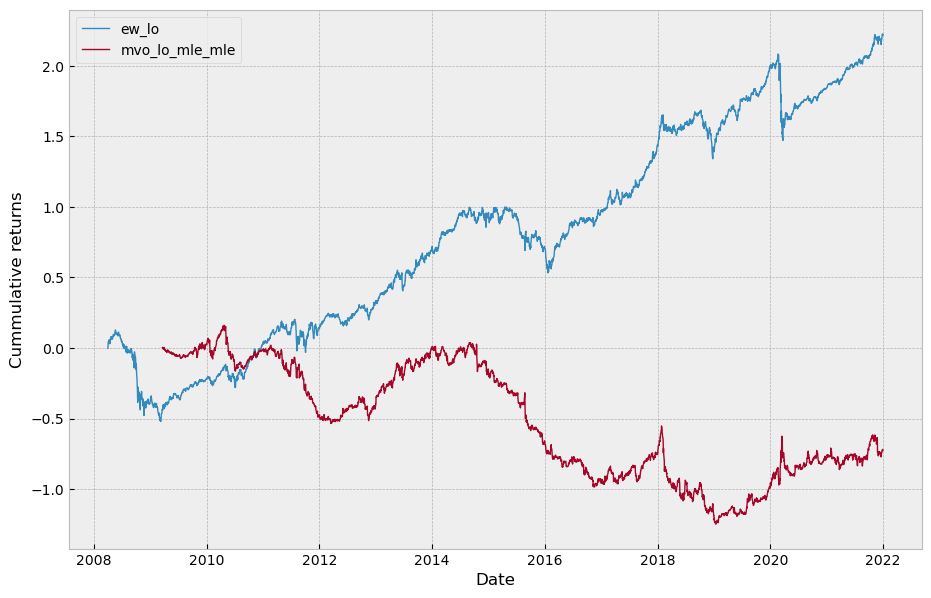

In [10]:
fig, ax = plt.subplots(figsize=(11, 7))
for model in model_names:
    summary_df = all_summary_df.loc[all_summary_df["model"] == model]

    portfolio_returns =  summary_df.groupby("date").sum()[["pnl"]]
    portfolio_vol = (portfolio_returns.rolling(window=252).std() * np.sqrt(252)).shift(1)
    portfolio_returns_target = (portfolio_returns * (vol_target / portfolio_vol)).dropna()

    cum_pnl_df = portfolio_returns_target.loc["2007-01-01":].cumsum().reset_index()
    ax.plot(pd.to_datetime(cum_pnl_df['date']), cum_pnl_df["pnl"], label=model)

plt.xlabel("Date")
plt.ylabel("Cummulative returns")
plt.legend(loc='best', fontsize=10)   
fig.savefig(os.path.join(results_path, "all_cummulative_returns_lo.png"), dpi=300)
plt.show()

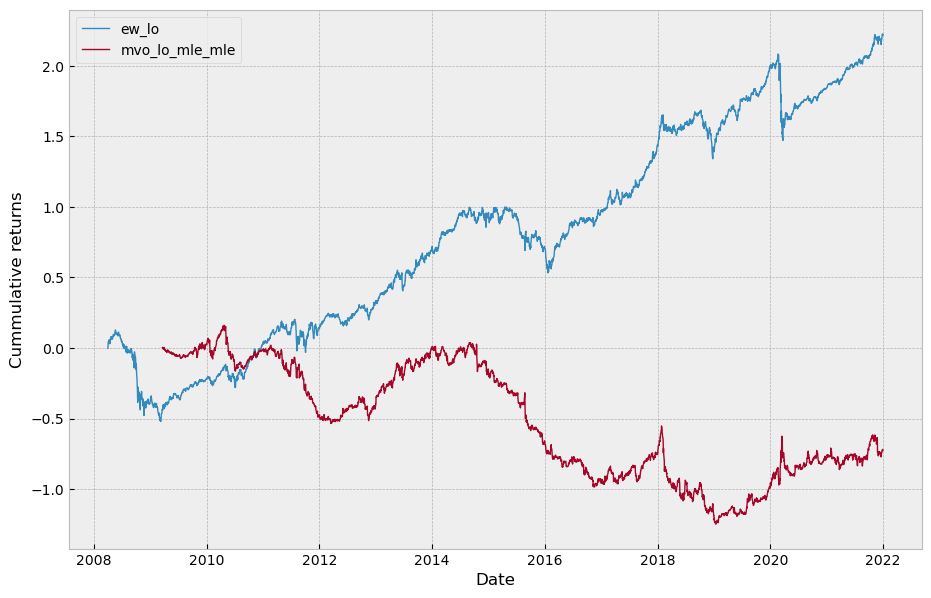

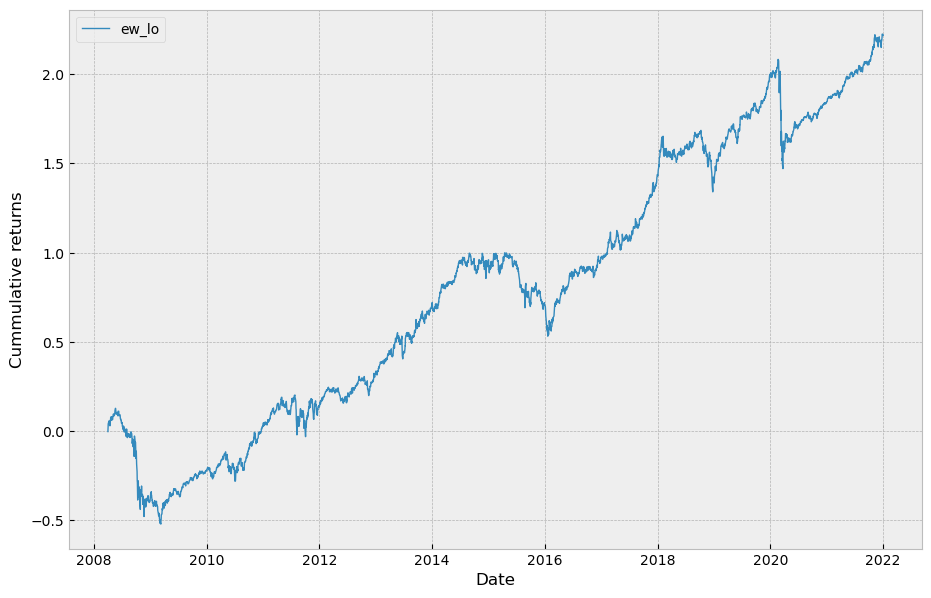

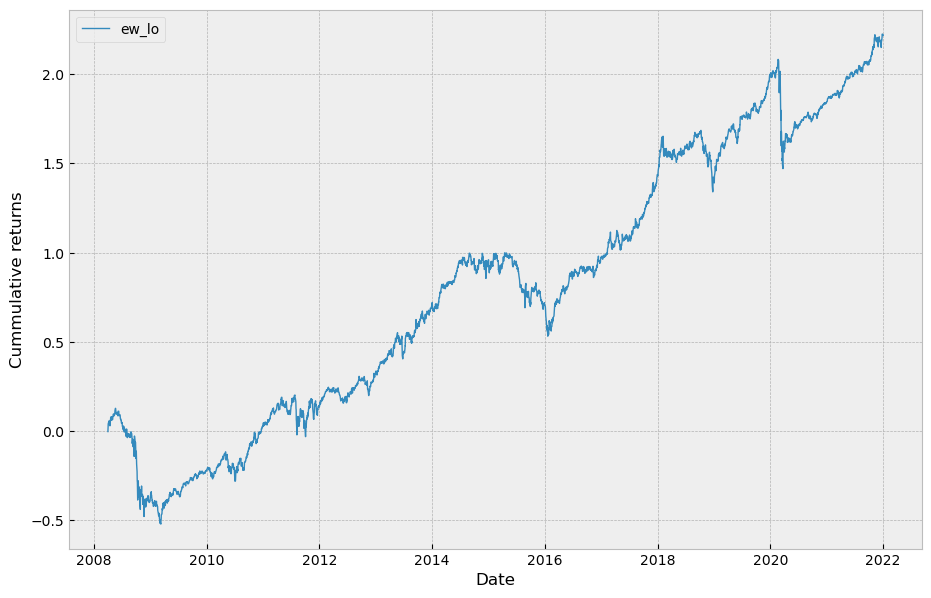

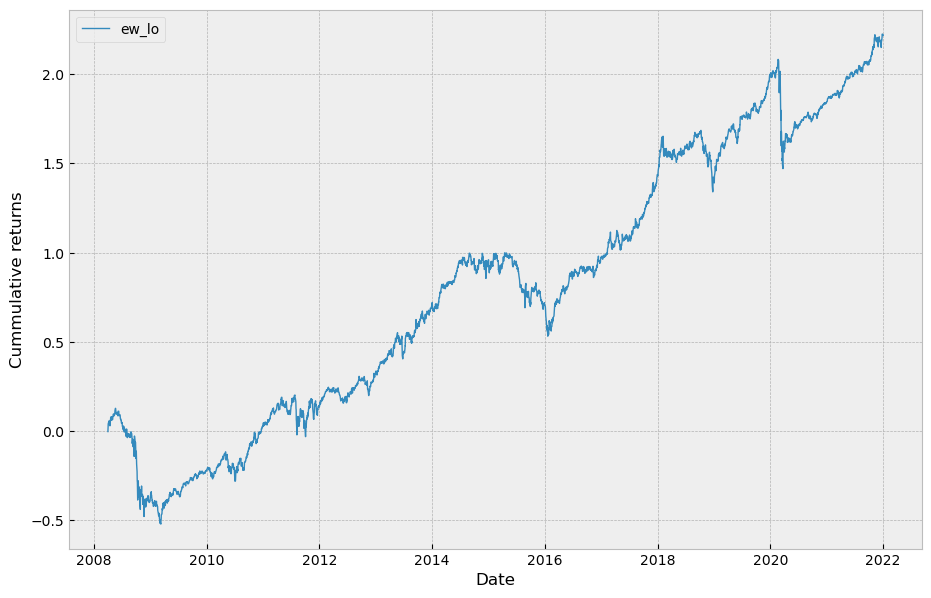

In [11]:
for group in group_names:
    fig, ax = plt.subplots(figsize=(11, 7))
    for model in [name for name in model_names if ("ew" == name.split("_")[0]) or (group == name.split("_")[0])]:
        summary_df = all_summary_df.loc[all_summary_df["model"] == model]

        portfolio_returns =  summary_df.groupby("date").sum()[["pnl"]]
        portfolio_vol = (portfolio_returns.rolling(window=252).std() * np.sqrt(252)).shift(1)
        portfolio_returns_target = (portfolio_returns * (vol_target / portfolio_vol)).dropna()

        cum_pnl_df = portfolio_returns_target.loc["2007-01-01":].cumsum().reset_index()
        ax.plot(pd.to_datetime(cum_pnl_df['date']), cum_pnl_df["pnl"], label=model)

    plt.xlabel("Date")
    plt.ylabel("Cummulative returns")
    plt.legend(loc='best', fontsize=10)   
    fig.savefig(os.path.join(results_path, f"{group}_cummulative_returns_lo.png"), dpi=300)
    plt.show()

## 3) Boxplot with the Sharpe Ratio for each Monte Carlo Sample

## 4) Forecast Comparison - Diebold-Mariano Test